In [1]:
import os, time
import matplotlib.pyplot as plt
import numpy as np
import dgl
import dgl.nn.functional as fn
import pickle as pkl
import torch
from sklearn.metrics import recall_score, precision_score, roc_auc_score

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import collections

In [3]:
import seaborn
import matplotlib.ticker as ticker

In [4]:
import torch.nn.functional as F

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8, 8]

In [6]:
from utils import *
from xgnn_src.node.eval import *

In [7]:
Arg = collections.namedtuple("Arg", ["teacher_name", "hidden_sizes", "n_layers", "dropout", "n_hidden", "n_heads", "n_out_heads", "negative_slope", "residual", "all_layer_dp", "skip_norm"])

```
python train.py --teacher-name gat --dataset TRC --n-epochs 1000 --n-hidden 64 
--n-layers 3 --n-heads 1 --lr 0.01 --all-layer-dp --skip-norm --add-reverse --gpu 0 --teacher-pretrain ./ckpt/gat/tree_cycle01.pt

python train.py --teacher-name gat --dataset TRG --n-epochs 1000 --n-hidden 64 
--n-layers 3 --n-heads 1 --lr 0.01 --all-layer-dp --skip-norm --add-reverse --gpu 0 --teacher-pretrain ./ckpt/gat/tree_grid01.pt
```

### Using bidirected graph (default)

In [8]:
# ba_shape1.g, ba_shape.pt
with open('./datasets/tree_cycle_bidir.g', 'rb') as f:
    g = pkl.load(f)
num_classes = 2
test_labels = g.ndata['label'][g.ndata['test_mask']]
feats = g.ndata['feat'].size()[1]
arg = Arg("gat", [64], 3, 0.5, 64, 1, 1, 0.2, False, True, True)
model = init_teacher(arg, g, feats, num_classes)
ckpt = torch.load('./ckpt/gat/tree_cycle01.pt', map_location="cuda:0")
model.load_state_dict(ckpt)

GAT(
  (gat_layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=3, out_features=64, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=64, out_features=64, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (2): GATConv(
      (fc): Linear(in_features=64, out_features=64, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (3): GATConv(
      (fc): Linear(in_features=64, out_features=2, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
)


<All keys matched successfully>

In [9]:
compute_edge_weights(model, g, 'gat')

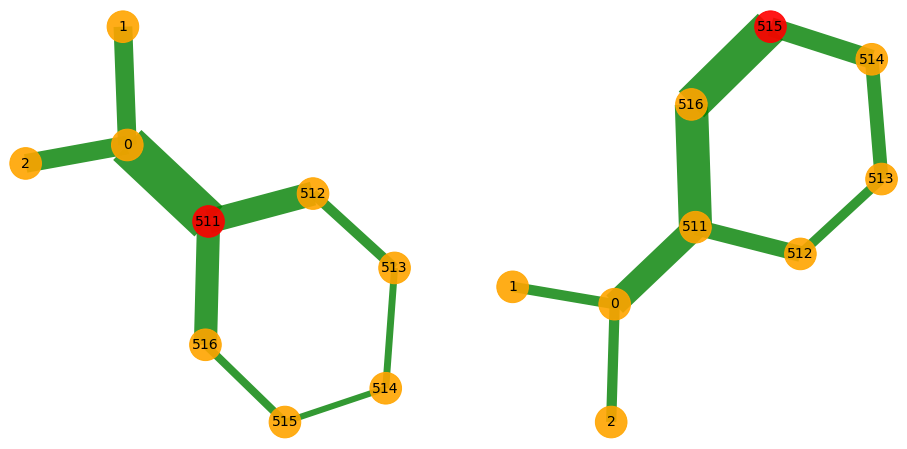

In [11]:
plt.rcParams["figure.figsize"] = [16, 8]
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = axes.flatten()
explain_test(g, 511, 13, ax=ax[0], undir=True, scale=30)
ax[0].set_axis_off()
# 103, 276, 289
explain_test(g, 515, 12, ax=ax[1], undir=True, scale=30)
ax[1].set_axis_off()
# plt.savefig('./images/ba_shape.svg', format="svg", dpi=300)

When a node connect to a high degree node => affected by this node when performing PPR

In [10]:
selected_node = list(range(511,871,6))
test_pentagon = [extract_true_motif(g, i, 510, 6) for i in selected_node]

In [16]:
s = time.time()
pred, rec, best_options = evaluate_dataset(g, selected_node, test_pentagon, 6, 10, ignore_self_loop=True, dumping_factor=0.9)
print(time.time() - s)
print("Precision: %.4f Recall %.4f F1 %.4f"  % (pred, rec, pred*rec*2/(pred+rec)))

60it [00:04, 12.02it/s]

5.000997304916382
Precision: 0.8359 Recall 0.7902 F1 0.8124


In [17]:
s = time.time()
graphs = khop_batch(model, g, selected_node, 3, model_name='gat')
eval_dataset2(test_pentagon, graphs)
print(time.time() - s)

F1 Score: 0.717949
P Score: 0.681648
R score: 0.758333
0.1731252670288086


## Tree Grid

In [17]:
with open('./datasets/tree_grid_bidir.g', 'rb') as f:
    g1 = pkl.load(f)

num_classes = 2
g1 = dgl.remove_self_loop(g1)
g1 = dgl.add_self_loop(g1)
test_labels1 = g1.ndata['label'][g1.ndata['test_mask']]
feats1 = g1.ndata['feat'].size()[1]
arg1 = Arg("gat", [64], 3, 0.5, 64, 1, 1, 0.2, False, True, True)
model1 = init_teacher(arg1, g1, feats1, num_classes)
ckpt1 = torch.load('./ckpt/gat/tree_grid01.pt', map_location="cuda:0")
model1.load_state_dict(ckpt1)

GAT(
  (gat_layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=3, out_features=64, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=64, out_features=64, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (2): GATConv(
      (fc): Linear(in_features=64, out_features=64, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (3): GATConv(
      (fc): Linear(in_features=64, out_features=2, bias=False)
      (feat_drop): Dropout(p=0.5, inplace=False)
      (attn_drop): Dropout(p=0.5, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
)


<All keys matched successfully>

In [18]:
compute_edge_weights(model1, g1, 'gat')

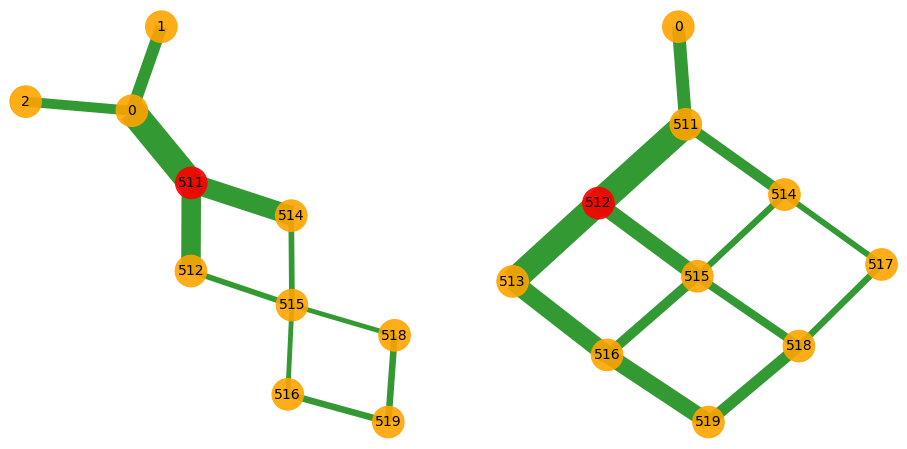

In [10]:
plt.rcParams["figure.figsize"] = [16, 8]
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = axes.flatten()
explain_test(g1, 511, 10, ax=ax[0], scale=20)
ax[0].set_axis_off()
explain_test(g1, 512, 10, ax=ax[1], scale=20)
ax[1].set_axis_off()
# plt.savefig('./images/ba_community.svg', format="svg", dpi=300)

In [19]:
selected = list(range(511,800,1))
test_graphs = [extract_true_motif(g1, i, 510, 9) for i in selected]

In [22]:
s = time.time()
pred1, rec1, best_options2 = evaluate_dataset(g1, selected, test_graphs, 10, 12, ignore_self_loop=True, dumping_factor=0.9)
print(time.time() - s)

289it [00:13, 20.66it/s]

14.019140005111694


In [23]:
print("F1: %.4f Precision: %.4f Recall %.4f"  % (pred1*rec1*2/(pred1+rec1), pred1, rec1))

F1: 0.7323 Precision: 0.8411 Recall 0.6484


In [11]:
s = time.time()
grid_graphs = khop_batch(model1, g1, selected, 5, model_name='gat', sym=True)
eval_dataset2(test_graphs, grid_graphs, selected)
print(time.time() - s)

F1 Score: 0.301824
P Score: 0.259363
R score: 0.360910
1.0788402557373047


In [14]:
s = time.time()
grid_graphs = khop_batch(model1, g1, selected, 4, model_name='gat', sym=False)
eval_dataset2(test_graphs, grid_graphs, selected)
print(time.time() - s)

F1 Score: 0.388641
P Score: 0.547116
R score: 0.301353
0.9980068206787109
